initializing...
acc var: [0.02438843 0.00541696 0.00569319], norm: 0.025623255301686715
ang var: [0.10057473 1.12895031 0.24520243], norm: 1.159641456857599
mag var: [ 2.437416 16.449696  7.618464], norm: 18.29137744864414
--------
processing...


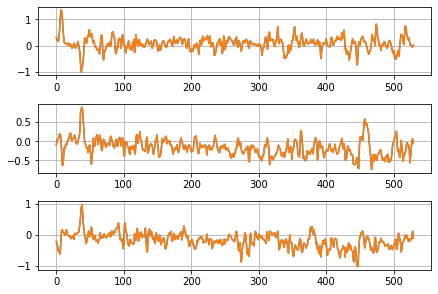

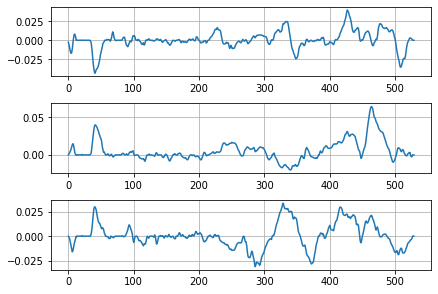

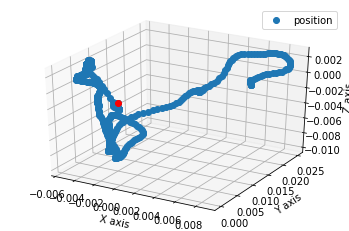

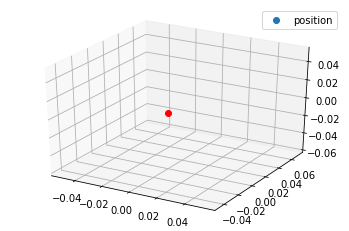

In [5]:
import numpy as np
from numpy.linalg import inv, norm
import csv
# import data_receiver
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# plt.style.use('fivethirtyeight')


def plotSignal(al: list, wl: list, ml: list):
    f, ax = plt.subplots(ncols=3, nrows=3)
    plot3(al, ax=ax[:, 0])
    plot3(wl, ax=ax[:, 1])
    plot3(ml, ax=ax[:, 2])
    ax[0, 0].set_ylabel('x')
    ax[1, 0].set_ylabel('y')
    ax[2, 0].set_ylabel('z')
    ax[2, 0].set_xlabel('a')
    ax[2, 1].set_xlabel(r'$\omega$')
    ax[2, 2].set_xlabel('m')


def plotgAndAcc(g, ab):
    '''
    plot tracked gravity and body frame acceleration
    '''

    fig, ax = plt.subplots(nrows=1, ncols=3)
    plot3([g, ab],
          ax=ax,
          lims=[[None, [-12, 12]]] * 3,
          labels=[['$g_x$', '$g_y$', '$g_z$'], ['$a^b_x$', '$a^b_y$', '$a^b_z$']],
          show_legend=True)


def plot3(data, ax=None, lims=None, labels=None, show=False, show_legend=False):
    '''
    @param data: [ndarray, ...]
    @param lims: [[[xl, xh], [yl, yh]], ...]
    @param labels: [[label_string, ...], ...]
    '''

    show_flag = False
    if ax is None:
        show_flag = True
        f, ax = plt.subplots(ncols=1, nrows=3)

    for axel in range(3):
        has_label = False
        for n in range(len(data)):
            d = data[n]
            label = labels[n] if labels is not None else None

            if label is not None:
                ax[axel].plot(d[:, axel], label=label[axel])
                has_label = True
            else:
                ax[axel].plot(d[:, axel])

            lim = lims[axel] if lims is not None else None
            if lim is not None:
                if lim[0] is not None:
                    ax[axel].set_xlim(lim[0][0], lim[0][1])
                if lim[1] is not None:
                    ax[axel].set_ylim(lim[1][0], lim[1][1])

        if (has_label is not None) and show_legend:
            ax[axel].legend()
        ax[axel].grid(True)

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    if show or show_flag:
        plt.show()
    return ax


def plot3D(data, lim=None, ax=None):
    '''
    @param data: [[data, label_string], ...]
    @param lim: [[xl, xh], [yl, yh], [zl, zh]]
    '''

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    for item in data:
        label = item[1]
        d = item[0]
        ax.plot(d[:, 0], d[:, 1], d[:, 2], 'o', label=label)

    if lim is not None:
        if lim[0] is not None:
            ax.set_xlim(lim[0][0], lim[0][1])
        if lim[1] is not None:
            ax.set_ylim(lim[1][0], lim[1][1])
        if lim[2] is not None:
            ax.set_zlim(lim[2][0], lim[2][1])

    ax.legend()
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.plot([0], [0], [0], 'ro')
    plt.show()


# ----------------------------- #
# ---- Animated Plots ----
# ----------------------------- #


def plot3DAnimated(data, lim=[[-1, 1], [-1, 1], [-1, 1]], label=None, interval=10, show=True, repeat=True):
    '''
    @param data: (n, 3) ndarray
    @param lim: [[xl, xh], [yl, yh], [zl, zh]]
    @param show: if it's set to false, you can call this function multiple times to draw multiple lines
    '''

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    if label is not None:
        ln, = ax.plot([], [], [], 'o', label=label)
    else:
        ln, = ax.plot([], [], [], 'o')

    def init():
        ax.plot([0], [0], [0], 'ro')
        ax.set_xlim(lim[0][0], lim[0][1])
        ax.set_ylim(lim[1][0], lim[1][1])
        ax.set_zlim(lim[2][0], lim[2][1])
        if label is not None:
            ax.legend()
        return ln,

    def update(frame):
        ln.set_xdata(data[:frame, 0])
        ln.set_ydata(data[:frame, 1])
        ln.set_3d_properties(data[:frame, 2])
        return ln,

    FuncAnimation(fig,
                        update,
                        frames=range(1,
                                     np.shape(data)[0] + 1),
                        init_func=init,
                        blit=True,
                        interval=interval,
                        repeat=repeat)
    if show:
        plt.show()


def normalized(x):
    try:
        return x / np.linalg.norm(x)
    except:
        return x


def I(n):
    '''
    unit matrix
    just making its name prettier than np.eye
    '''
    return np.eye(n)


def skew(x):
    '''
    takes in a 3d column vector
    returns its Skew-symmetric matrix
    '''

    x = x.T[0]
    return np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])


def rotate(q):
    '''
    rotation transformation matrix
    nav frame to body frame as q is expected to be q^nb
    R(q) @ x to rotate x
    '''

    qv = q[1:4, :]
    qc = q[0]
    return (qc**2 - qv.T @ qv) * I(3) - 2 * qc * skew(qv) + 2 * qv @ qv.T


def F(q, wt, dt):
    '''state transfer matrix'''

    w = wt.T[0]
    Omega = np.array([[0, -w[0], -w[1], -w[2]], [w[0], 0, w[2], -w[1]],
                      [w[1], -w[2], 0, w[0]], [w[2], w[1], -w[0], 0]])

    return I(4) + 0.5 * dt * Omega


def G(q):
    '''idk what its called '''

    q = q.T[0]
    return 0.5 * np.array([[-q[1], -q[2], -q[3]], [q[0], -q[3], q[2]],
                           [q[3], q[0], -q[1]], [-q[2], q[1], q[0]]])


def Hhelper(q, vector):
    # just for convenience
    x = vector.T[0][0]
    y = vector.T[0][1]
    z = vector.T[0][2]
    q0 = q.T[0][0]
    q1 = q.T[0][1]
    q2 = q.T[0][2]
    q3 = q.T[0][3]

    h = np.array([
        [q0*x - q3*y + q2*z, q1*x + q2*y + q3*z, -q2*x + q1*y + q0*z, -q3*x - q0*y + q1*z],
        [q3*x + q0*y - q1*z, q2*x - q1*y - q0*z, q1*x + q2*y + q3*z, q0*x - q3*y + q2*z],
        [-q2*x + q1*y + q0*z, q3*x + q0*y - q1*z, -q0*x + q3*y - q2*z, q1*x + q2*y + q3*z]
    ])
    return 2 * h


def H(q, gn, mn):
    '''
    Measurement matrix
    '''

    H1 = Hhelper(q, gn)
    H2 = Hhelper(q, mn)
    return np.vstack((-H1, H2))


# def filtSignal(data, dt=0.01, wn=10, btype='lowpass', order=1):
#     '''
#     filter all data at once
#     uses butterworth filter of scipy
#     @param data: [...]
#     @param dt: sampling time
#     @param wn: critical frequency
#     '''

#     res = []
#     n, s = scipy.signal.butter(order, wn, fs=1 / dt, btype=btype)
#     for d in data:
#         d = scipy.signal.filtfilt(n, s, d, axis=0)
#         res.append(d)
#     return res


class IMUTracker:

    def __init__(self, sampling, data_order={'w': 1, 'a': 2, 'm': 3}):
        '''
        @param sampling: sampling rate of the IMU, in Hz
        @param tinit: initialization time where the device is expected to be stay still, in second
        @param data_order: specify the order of data in the data array
        '''

        super().__init__()
        # ---- parameters ----
        self.sampling = sampling
        self.dt = 1 / sampling    # second
        self.data_order = data_order

        # ---- helpers ----
        idx = {1: [0, 3], 2: [3, 6], 3: [6, 9]}
        self._widx = idx[data_order['w']]
        self._aidx = idx[data_order['a']]
        self._midx = idx[data_order['m']]

    def initialize(self, data, noise_coefficient={'w': 100, 'a': 100, 'm': 10}):
        '''
        Algorithm initialization
        
        @param data: (,9) ndarray
        @param cut: cut the first few data to avoid potential corrupted data
        @param noise_coefficient: sensor noise is determined by variance magnitude times this coefficient
        
        Return: a list of initialization values used by EKF algorithm: 
        (gn, g0, mn, gyro_noise, gyro_bias, acc_noise, mag_noise)
        '''

        # discard the first few readings
        # for some reason they might fluctuate a lot
        w = data[:, self._widx[0]:self._widx[1]]
        a = data[:, self._aidx[0]:self._aidx[1]]
        m = data[:, self._midx[0]:self._midx[1]]

        # ---- gravity ----
        gn = -a.mean(axis=0)
        gn = gn[:, np.newaxis]
        # save the initial magnitude of gravity
        g0 = np.linalg.norm(gn)

        # ---- magnetic field ----
        mn = m.mean(axis=0)
        # magnitude is not important
        mn = normalized(mn)[:, np.newaxis]

        # ---- compute noise covariance ----
        avar = a.var(axis=0)
        wvar = w.var(axis=0)
        mvar = m.var(axis=0)
        print('acc var: %s, norm: %s' % (avar, np.linalg.norm(avar)))
        print('ang var: %s, norm: %s' % (wvar, np.linalg.norm(wvar)))
        print('mag var: %s, norm: %s' % (mvar, np.linalg.norm(mvar)))

        # ---- define sensor noise ----
        gyro_noise = noise_coefficient['w'] * np.linalg.norm(wvar)
        gyro_bias = w.mean(axis=0)
        acc_noise = noise_coefficient['a'] * np.linalg.norm(avar)
        mag_noise = noise_coefficient['m'] * np.linalg.norm(mvar)
        return (gn, g0, mn, gyro_noise, gyro_bias, acc_noise, mag_noise)

    def attitudeTrack(self, data, init_list):
        '''
        Removes gravity from acceleration data and transform it into navitgaion frame.
        Also tracks device's orientation.
        
        @param data: (,9) ndarray
        @param list: initialization values for EKF algorithm:
        (gn, g0, mn, gyro_noise, gyro_bias, acc_noise, mag_noise)
        Return: (acc, orientation)
        '''

        # ------------------------------- #
        # ---- Initialization ----
        # ------------------------------- #
        gn, g0, mn, gyro_noise, gyro_bias, acc_noise, mag_noise = init_list
        w = data[:, self._widx[0]:self._widx[1]] - gyro_bias
        a = data[:, self._aidx[0]:self._aidx[1]]
        m = data[:, self._midx[0]:self._midx[1]]
        sample_number = np.shape(data)[0]

        # ---- data container ----
        a_nav = []
        orix = []
        oriy = []
        oriz = []

        # ---- states and covariance matrix ----
        P = 1e-10 * I(4)    # state covariance matrix
        q = np.array([[1, 0, 0, 0]]).T    # quaternion state
        init_ori = I(3)   # initial orientation

        # ------------------------------- #
        # ---- Extended Kalman Filter ----
        # ------------------------------- #

        # all vectors are column vectors

        t = 0
        while t < sample_number:

            # ------------------------------- #
            # ---- 0. Data Preparation ----
            # ------------------------------- #

            wt = w[t, np.newaxis].T
            at = a[t, np.newaxis].T
            mt = normalized(m[t, np.newaxis].T)

            # ------------------------------- #
            # ---- 1. Propagation ----
            # ------------------------------- #

            Ft = F(q, wt, self.dt)
            Gt = G(q)
            Q = (gyro_noise * self.dt)**2 * Gt @ Gt.T

            q = normalized(Ft @ q)
            P = Ft @ P @ Ft.T + Q

            # ------------------------------- #
            # ---- 2. Measurement Update ----
            # ------------------------------- #

            # Use normalized measurements to reduce error!

            # ---- acc and mag prediction ----
            pa = normalized(-rotate(q) @ gn)
            pm = normalized(rotate(q) @ mn)

            # ---- residual ----
            Eps = np.vstack((normalized(at), mt)) - np.vstack((pa, pm))

            # ---- sensor noise ----
            # R = internal error + external error
            Ra = [(acc_noise / np.linalg.norm(at))**2 + (1 - g0 / np.linalg.norm(at))**2] * 3
            Rm = [mag_noise**2] * 3
            R = np.diag(Ra + Rm)

            # ---- kalman gain ----
            Ht = H(q, gn, mn)
            S = Ht @ P @ Ht.T + R
            K = P @ Ht.T @ np.linalg.inv(S)

            # ---- actual update ----
            q = q + K @ Eps
            P = P - K @ Ht @ P

            # ------------------------------- #
            # ---- 3. Post Correction ----
            # ------------------------------- #

            q = normalized(q)
            P = 0.5 * (P + P.T)    # make sure P is symmertical

            # ------------------------------- #
            # ---- 4. other things ----
            # ------------------------------- #

            # ---- navigation frame acceleration ----
            conj = -I(4)
            conj[0, 0] = 1
            an = rotate(conj @ q) @ at + gn

            # ---- navigation frame orientation ----
            orin = rotate(conj @ q) @ init_ori

            # ---- saving data ----
            a_nav.append(an.T[0])
            orix.append(orin.T[0, :])
            oriy.append(orin.T[1, :])
            oriz.append(orin.T[2, :])

            t += 1

        a_nav = np.array(a_nav)
        orix = np.array(orix)
        oriy = np.array(oriy)
        oriz = np.array(oriz)
        return (a_nav, orix, oriy, oriz)

    def removeAccErr(self, a_nav, threshold=0.2, filter=False, wn=(0.01, 15)):
        '''
        Removes drift in acc data assuming that
        the device stays still during initialization and ending period.
        The initial and final acc are inferred to be exactly 0.
        The final acc data output is passed through a bandpass filter to further reduce noise and drift.
        
        @param a_nav: acc data, raw output from the kalman filter
        @param threshold: acc threshold to detect the starting and ending point of motion
        @param wn: bandpass filter cutoff frequencies
        
        Return: corrected and filtered acc data
        '''

        sample_number = np.shape(a_nav)[0]
        t_start = 0
        for t in range(sample_number):
            at = a_nav[t]
            if np.linalg.norm(at) > threshold:
                t_start = t
                break

        t_end = 0
        for t in range(sample_number - 1, -1, -1):
            at = a_nav[t]
            if np.linalg.norm(at - a_nav[-1]) > threshold:
                t_end = t
                break

        an_drift = a_nav[t_end:].mean(axis=0)
        an_drift_rate = an_drift / (t_end - t_start)

        for i in range(t_end - t_start):
            a_nav[t_start + i] -= (i + 1) * an_drift_rate

        for i in range(sample_number - t_end):
            a_nav[t_end + i] -= an_drift
        
        return a_nav

        # if filter:
        #     filtered_a_nav = filtSignal([a_nav], dt=self.dt, wn=wn, btype='bandpass')[0]
        #     return filtered_a_nav
        # else:
        #     return a_nav

    def zupt(self, a_nav, threshold):
        '''
        Applies Zero Velocity Update(ZUPT) algorithm to acc data.
        
        @param a_nav: acc data
        @param threshold: stationary detection threshold, the more intense the movement is the higher this should be
        Return: velocity data
        '''

        sample_number = np.shape(a_nav)[0]
        velocities = []
        prevt = -1
        still_phase = False

        v = np.zeros((3, 1))
        t = 0
        while t < sample_number:
            at = a_nav[t, np.newaxis].T

            if np.linalg.norm(at) < threshold:
                if not still_phase:
                    predict_v = v + at * self.dt

                    v_drift_rate = predict_v / (t - prevt)
                    for i in range(t - prevt - 1):
                        velocities[prevt + 1 + i] -= (i + 1) * v_drift_rate.T[0]

                v = np.zeros((3, 1))
                prevt = t
                still_phase = True
            else:
                v = v + at * self.dt
                still_phase = False

            velocities.append(v.T[0])
            t += 1

        velocities = np.array(velocities)
        return velocities

    def positionTrack(self, a_nav, velocities):
        '''
        Simple integration of acc data and velocity data.
        
        @param a_nav: acc data
        @param velocities: velocity data
        
        Return: 3D coordinates in navigation frame
        '''

        sample_number = np.shape(a_nav)[0]
        positions = []
        p = np.array([[0, 0, 0]]).T

        t = 0
        while t < sample_number:
            at = a_nav[t, np.newaxis].T
            vt = velocities[t, np.newaxis].T

            p = p + vt * self.dt + 0.5 * at * self.dt**2
            positions.append(p.T[0])
            t += 1

        positions = np.array(positions)
        return positions


def receive_data(mode='file'):
    data = []

    if mode == 'tcp':
        r = data_receiver.Receiver()
        file = open('data.txt', 'w')
        print('listening...')
        for line in r.receive():
            file.write(line)
            data.append(line.split(','))
        data = np.array(data, dtype=np.float)
        return data

    if mode == 'file':
        file = open('/content/drive/MyDrive/ColabNotebooks/DLSF/dataset/fusiondata.csv', 'r')
        for line in file.readlines():
            data.append(line.split(','))
        data = np.array(data, dtype=np.float)



        return data

    else:
        raise Exception('Invalid mode argument: ', mode)


def plot_trajectory():
    tracker = IMUTracker(sampling=100)
    data = receive_data('file')    # toggle data source between 'tcp' and 'file' here

    print('initializing...')
    init_list = tracker.initialize(data[5:30])

    print('--------')
    print('processing...')
    
    # EKF step
    a_nav, orix, oriy, oriz = tracker.attitudeTrack(data[30:], init_list)

    # Acceleration correction step
    a_nav_filtered = tracker.removeAccErr(a_nav, filter=False)
    plot3([a_nav, a_nav_filtered])

    # ZUPT step
    v = tracker.zupt(a_nav_filtered, threshold=0.2)
    plot3([v])

    # Integration Step
    p = tracker.positionTrack(a_nav_filtered, v)
    plot3D([[p, 'position']])
    
    # make 3D animation
    xl = np.min(p[:, 0]) - 0.05
    xh = np.max(p[:, 0]) + 0.05
    yl = np.min(p[:, 1]) - 0.05
    yh = np.max(p[:, 1]) + 0.05
    zl = np.min(p[:, 2]) - 0.05
    zh = np.max(p[:, 2]) + 0.05
    plot3DAnimated(p, lim=[[xl, xh], [yl, yh], [zl, zh]], label='position', interval=100)


if __name__ == '__main__':

    plot_trajectory()
    # data = receive_data('tcp')
    